# 🏥 Heart Failure Clinical Records Analysis

**Objective**  
Analyze survival of patients with heart failure using 13 clinical features.  
Dataset size: 299 patients.  

**Steps in Analysis**  
1. Dataset loading & inspection  
2. Data quality check (missing, duplicates)  
3. Outlier detection & handling (IQR method)  
4. Exploratory Data Analysis (EDA)  
5. Grouped analysis (age bins, comorbidities)  
6. Key presentation visuals  
7. Feature engineering (risk score)  
8. Baseline ML models (Logistic Regression & Random Forest)  
9. ROC & feature importance  
10. Save cleaned dataset + portfolio recommendations


In [1]:
# Imports and plotting settings (compatible with your versions)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

# plotting defaults for presentation
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['savefig.dpi'] = 300

# Print versions (for reproducibility)
import sys
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__, "numpy:", np.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)

Python: 3.13.7
pandas: 2.3.1 numpy: 2.3.2
scikit-learn: 1.7.1


## 1 — Load dataset  
Ensure `heart_failure_clinical_records_dataset.csv` is in the project folder. Load into a DataFrame and inspect.


In [5]:
csv_path = "heart_failure_clinical_records_dataset.csv"
assert os.path.exists(csv_path), f"File not found: {csv_path}"

df = pd.read_csv(csv_path)
print("Shape:", df.shape)

display(df.head())
display(df.info())
display(df.describe().T)


Shape: (299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


None

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


In [3]:
# Missing values
print("Missing values per column:\n", df.isnull().sum())

# Duplicates
dups = df.duplicated().sum()
print("\nDuplicate rows:", dups)

# Data types
print("\nData types:\n", df.dtypes)


Missing values per column:
 age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Duplicate rows: 0

Data types:
 age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


## Target variable overview (DEATH_EVENT)  
Check survival rate and balance of the target classes.  



DEATH_EVENT
0    203
1     96
Name: count, dtype: int64
Survival rate: 67.89%


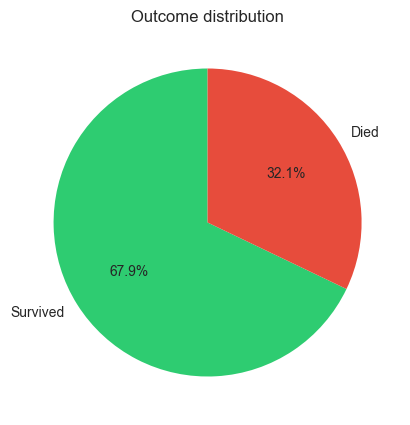

In [6]:
target = "DEATH_EVENT"
counts = df[target].value_counts()
print(counts)
print(f"Survival rate: {(1 - df[target].mean())*100:.2f}%")

plt.figure(figsize=(5,5))
colors = ["#2ecc71", "#e74c3c"]
plt.pie(counts.values, labels=["Survived","Died"], autopct="%1.1f%%", colors=colors, startangle=90)
plt.title("Outcome distribution")
plt.show()



## 3 — Outlier detection (IQR method)  
Detect outliers in continuous variables. Outliers will be capped (clipped).  



In [7]:
continuous_vars = ['age','creatinine_phosphokinase','ejection_fraction',
                   'platelets','serum_creatinine','serum_sodium','time']
present_cont = [c for c in continuous_vars if c in df.columns]

outlier_counts = {}
for var in present_cont:
    Q1, Q3 = df[var].quantile([0.25,0.75])
    IQR = Q3 - Q1
    lb, ub = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outlier_counts[var] = ((df[var] < lb) | (df[var] > ub)).sum()

outlier_counts


{'age': np.int64(0),
 'creatinine_phosphokinase': np.int64(29),
 'ejection_fraction': np.int64(2),
 'platelets': np.int64(21),
 'serum_creatinine': np.int64(29),
 'serum_sodium': np.int64(4),
 'time': np.int64(0)}

### 4 — Handle outliers (capping)  
Clip values at lower/upper bounds. Create `df_clean`.  


In [8]:
df_clean = df.copy()
for var in present_cont:
    Q1, Q3 = df[var].quantile([0.25,0.75])
    IQR = Q3 - Q1
    lb, ub = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df_clean[var] = df_clean[var].clip(lower=lb, upper=ub)

df_clean[present_cont].describe().T


,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.00
creatinine_phosphokinase,299.0,424.214883,385.449328,23.0,116.5,250.0,582.0,1280.25
ejection_fraction,299.0,38.033445,11.685643,14.0,30.0,38.0,45.0,67.50
platelets,299.0,259163.714883,81478.304369,76000.0,212500.0,262000.0,303500.0,440000.00
serum_creatinine,299.0,1.234515,0.440098,0.5,0.9,1.1,1.4,2.15
serum_sodium,299.0,136.712375,4.076971,125.0,134.0,137.0,140.0,148.00
time,299.0,130.260870,77.614208,4.0,73.0,115.0,203.0,285.00


## 5 — Correlation analysis  
Check feature correlations with the target.  


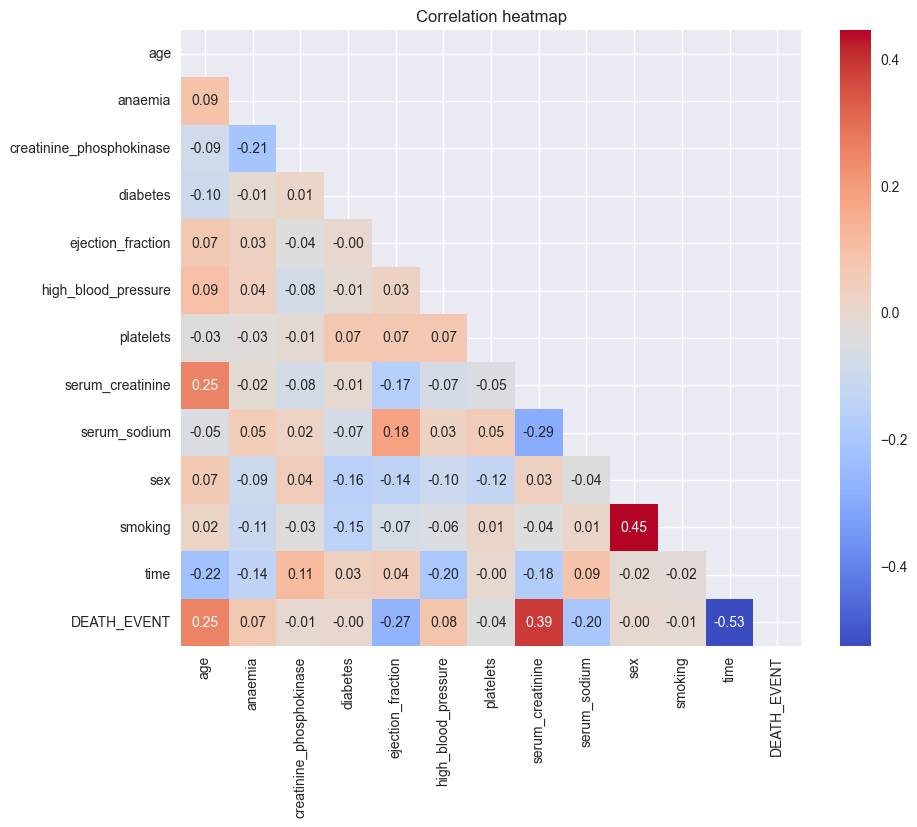

DEATH_EVENT                 1.000000
serum_creatinine            0.388469
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
diabetes                   -0.001943
sex                        -0.004316
creatinine_phosphokinase   -0.006355
smoking                    -0.012623
platelets                  -0.044132
serum_sodium               -0.201320
ejection_fraction          -0.270611
time                       -0.526964
Name: DEATH_EVENT, dtype: float64


In [9]:
plt.figure(figsize=(10,8))
corr = df_clean.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap")
plt.show()

print(corr[target].sort_values(ascending=False))


## 6 — Grouped analysis  
Analyze death rates by age groups and comorbidities.  


age_group
<50      0.234043
50-59    0.243902
60-69    0.290323
70-79    0.384615
80+      0.720000
Name: DEATH_EVENT, dtype: float64


C:\Users\nilsa\AppData\Local\Temp\ipykernel_15096\2809682682.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stats = df_clean.groupby("age_group")[target].mean()


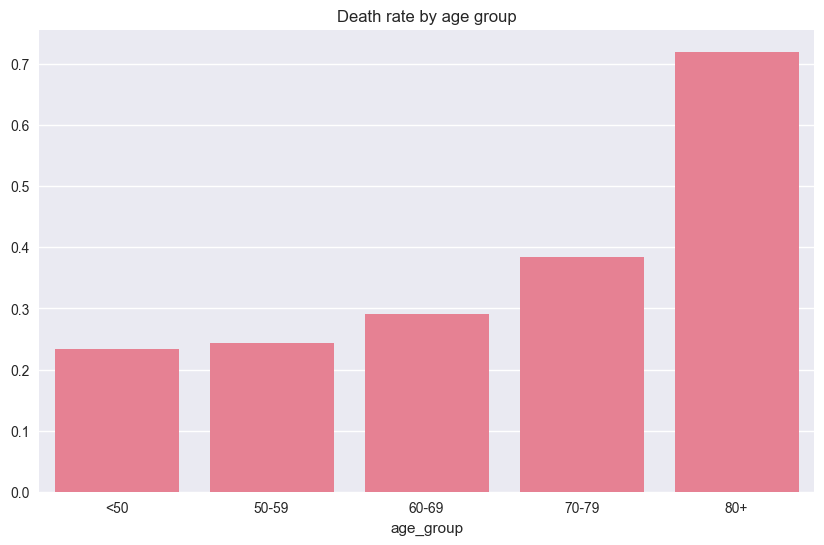

anaemia anaemia
0    0.294118
1    0.356589
Name: DEATH_EVENT, dtype: float64


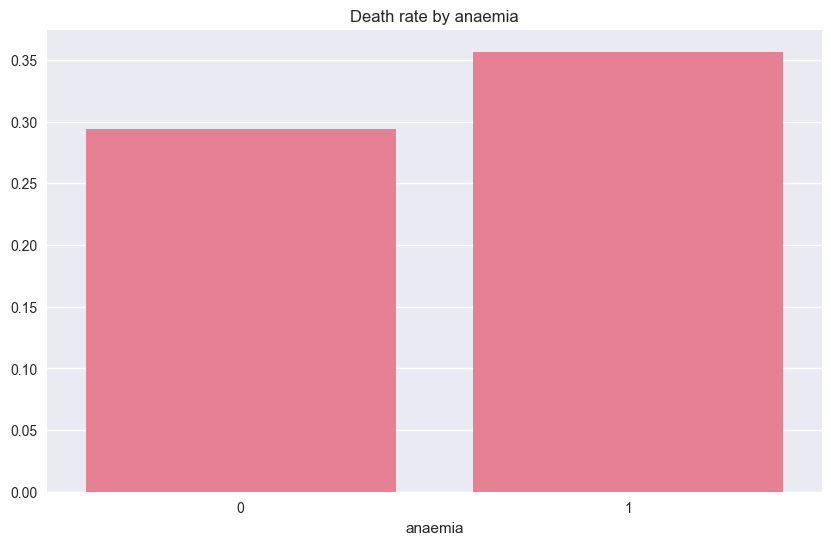

diabetes diabetes
0    0.321839
1    0.320000
Name: DEATH_EVENT, dtype: float64


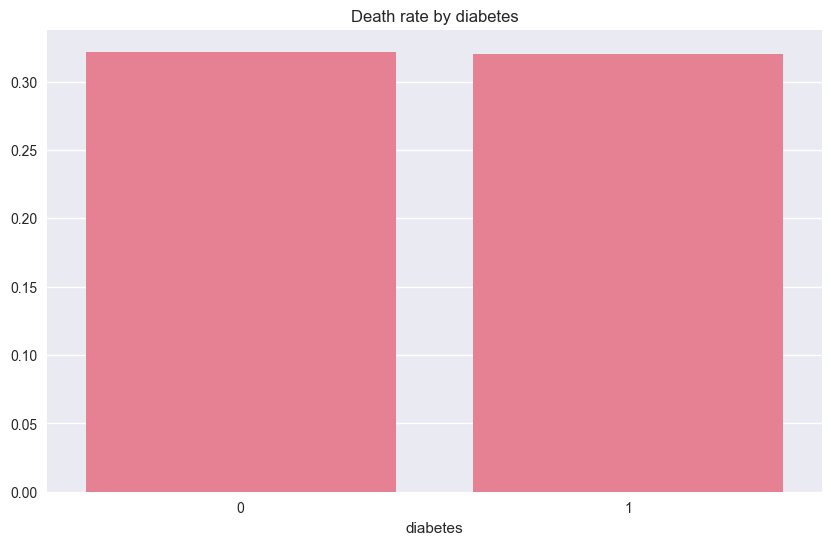

high_blood_pressure high_blood_pressure
0    0.293814
1    0.371429
Name: DEATH_EVENT, dtype: float64


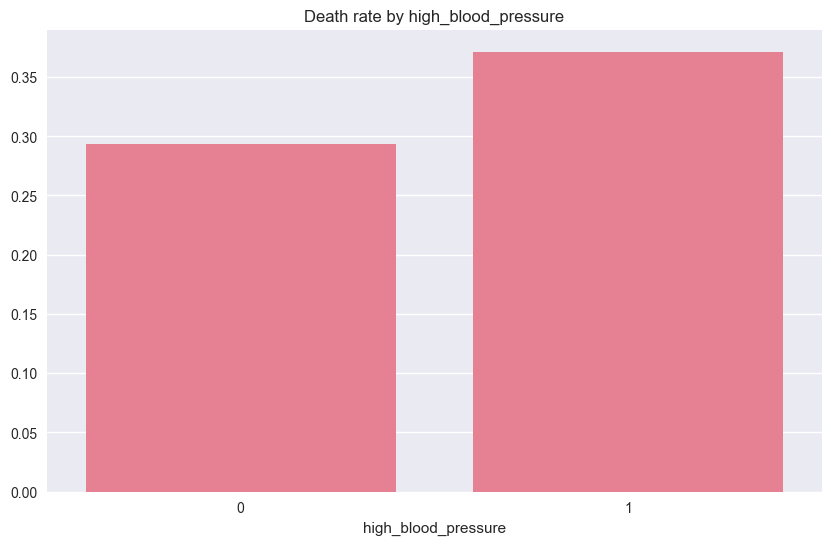

smoking smoking
0    0.325123
1    0.312500
Name: DEATH_EVENT, dtype: float64


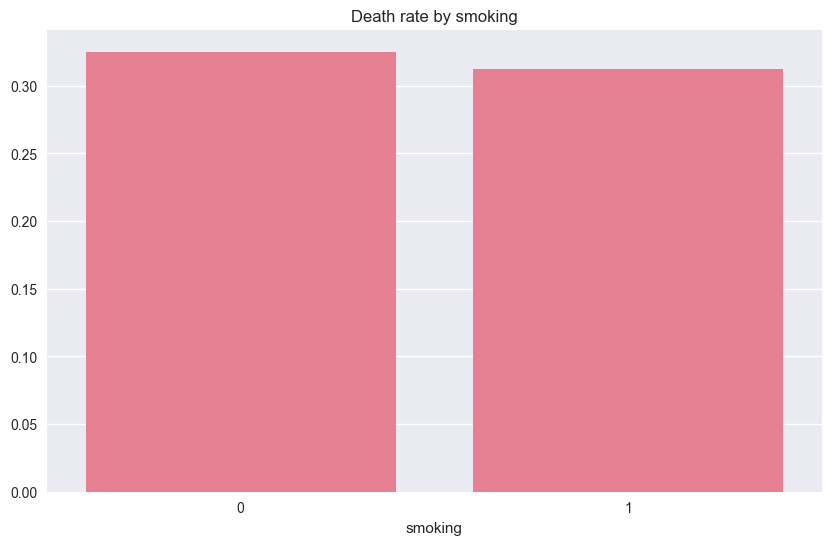

In [10]:
# Age groups
bins = [0,50,60,70,80,120]
labels = ["<50","50-59","60-69","70-79","80+"]
df_clean["age_group"] = pd.cut(df_clean["age"], bins=bins, labels=labels, right=False)

age_stats = df_clean.groupby("age_group")[target].mean()
print(age_stats)

sns.barplot(x=age_stats.index, y=age_stats.values)
plt.title("Death rate by age group")
plt.show()

# Comorbidities
for c in ["anaemia","diabetes","high_blood_pressure","smoking"]:
    if c in df_clean.columns:
        stats = df_clean.groupby(c)[target].mean()
        print(c, stats)
        sns.barplot(x=stats.index, y=stats.values)
        plt.title(f"Death rate by {c}")
        plt.show()


## 7 — Key visuals  
Histograms, boxplots, and scatterplots for presentation.  


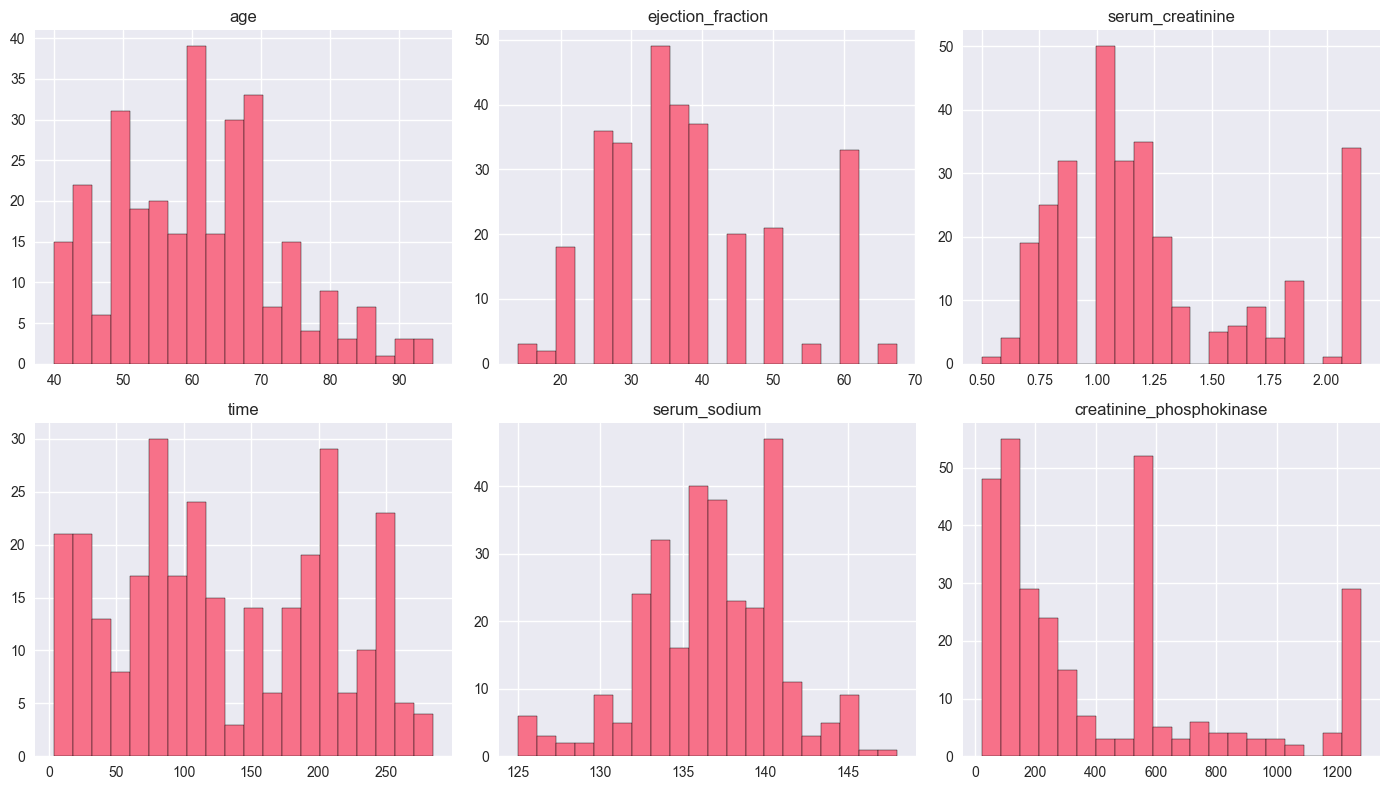

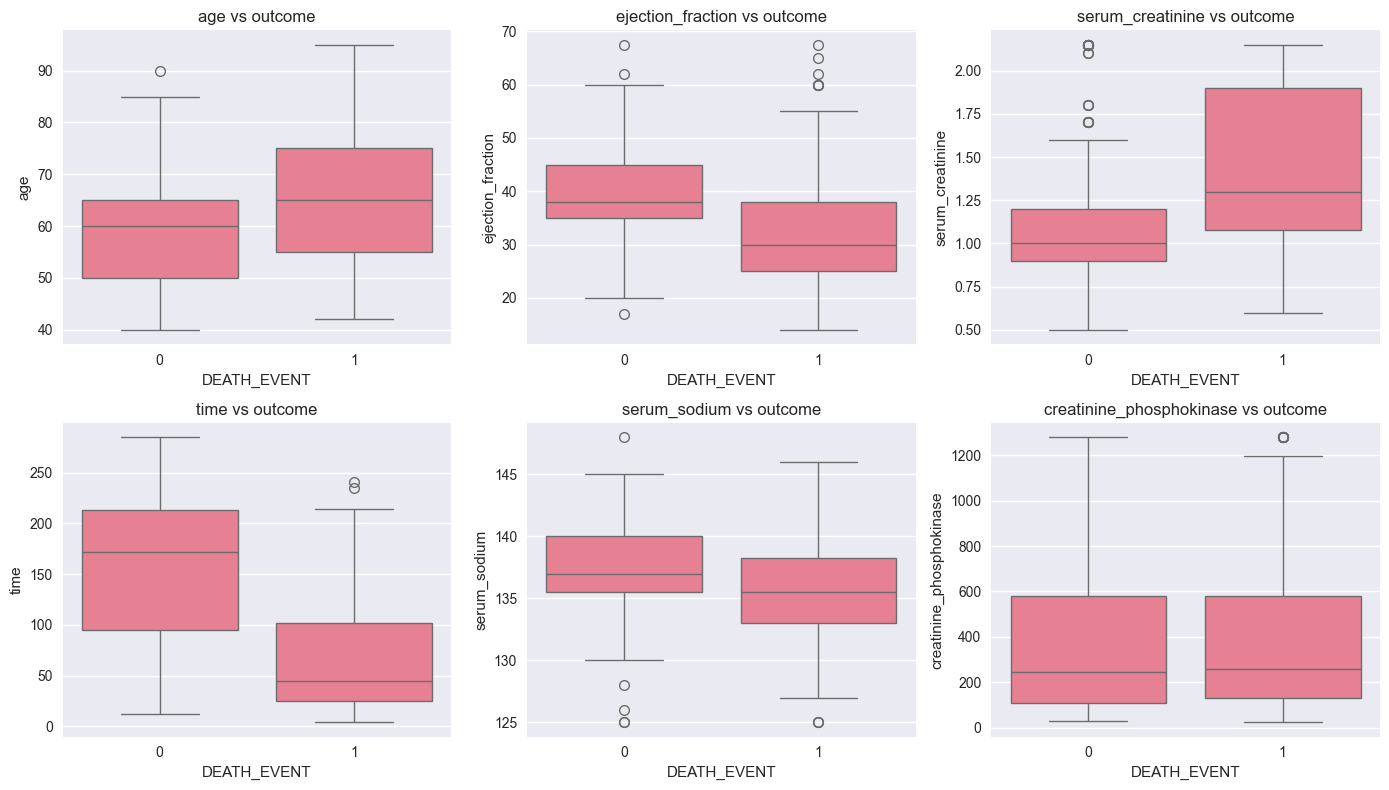

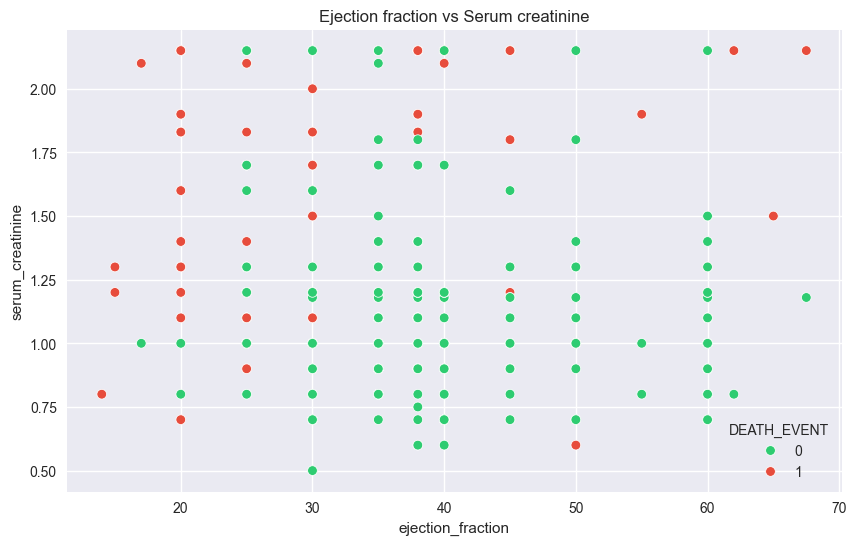

In [11]:
# Histograms
vars_plot = ['age','ejection_fraction','serum_creatinine','time','serum_sodium','creatinine_phosphokinase']
plt.figure(figsize=(14,8))
for i,v in enumerate(vars_plot,1):
    plt.subplot(2,3,i)
    plt.hist(df_clean[v], bins=20, edgecolor="k")
    plt.title(v)
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(14,8))
for i,v in enumerate(vars_plot,1):
    plt.subplot(2,3,i)
    sns.boxplot(x=target, y=v, data=df_clean)
    plt.title(f"{v} vs outcome")
plt.tight_layout()
plt.show()

# Scatter
sns.scatterplot(data=df_clean, x="ejection_fraction", y="serum_creatinine", hue=target,
                palette={0:"#2ecc71",1:"#e74c3c"})
plt.title("Ejection fraction vs Serum creatinine")
plt.show()


## 8 — Feature engineering  
Create EF category, creatinine category, comorbidity score, and clinical risk score.  


In [12]:
df_clean['ef_category'] = pd.cut(df_clean['ejection_fraction'], bins=[0,30,40,50,100],
                                 labels=['Severe(<30)','Moderate(30-40)','Mild(40-50)','Normal(>50)'])
df_clean['creatinine_cat'] = pd.cut(df_clean['serum_creatinine'], bins=[0,1.2,2.0,df_clean['serum_creatinine'].max()+1],
                                    labels=['Normal(<1.2)','Elevated(1.2-2.0)','High(>2.0)'])
df_clean['comorbidity_score'] = df_clean[['anaemia','diabetes','high_blood_pressure','smoking']].sum(axis=1)
df_clean['clinical_risk_score'] = ((df_clean['serum_creatinine']>1.4).astype(int) +
                                   (df_clean['ejection_fraction']<40).astype(int) +
                                   (df_clean['age']>70).astype(int) +
                                   df_clean['comorbidity_score'])
df_clean[['age','ejection_fraction','serum_creatinine','comorbidity_score','clinical_risk_score']].head()


,age,ejection_fraction,serum_creatinine,comorbidity_score,clinical_risk_score
0,75.0,20.0,1.90,1,4
1,55.0,38.0,1.10,0,1
2,65.0,20.0,1.30,1,2
3,50.0,20.0,1.90,1,3
4,65.0,20.0,2.15,2,4


## 9 — Baseline machine learning  
Logistic Regression (scaled) and Random Forest (unscaled).  


In [13]:
features = ['age','ejection_fraction','serum_creatinine','serum_sodium','creatinine_phosphokinase','time','comorbidity_score']
X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

# Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled,y_train)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]
auc_lr = roc_auc_score(y_test,y_proba_lr)

# Random Forest
rf = RandomForestClassifier(n_estimators=200,max_depth=6,random_state=42)
rf.fit(X_train,y_train)
y_proba_rf = rf.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_test,y_proba_rf)

print("AUC LR:",auc_lr,"AUC RF:",auc_rf)


AUC LR: 0.8613607188703465 AUC RF: 0.8973042362002567


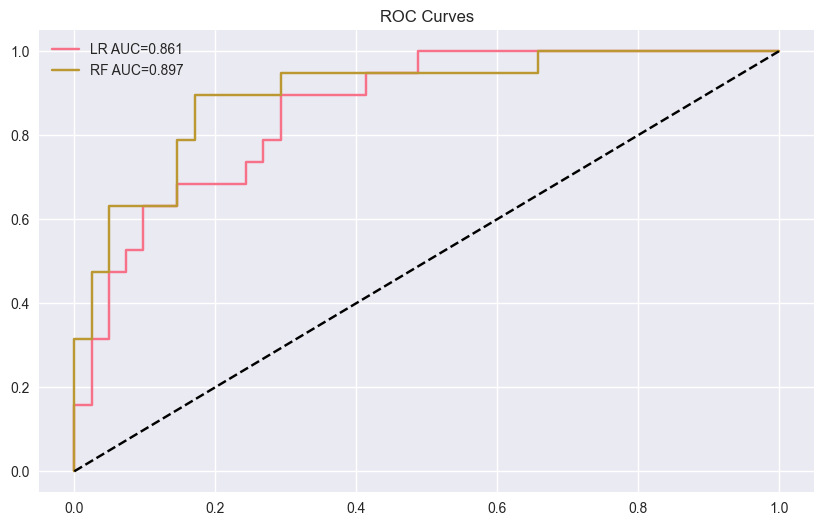

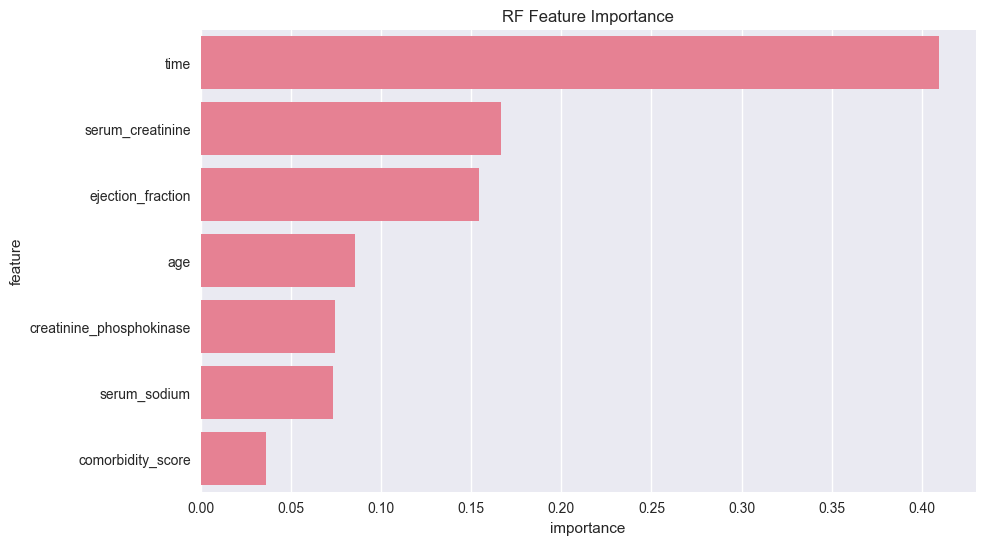

In [14]:
# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.plot(fpr_lr,tpr_lr,label=f"LR AUC={auc_lr:.3f}")
plt.plot(fpr_rf,tpr_rf,label=f"RF AUC={auc_rf:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.legend(); plt.title("ROC Curves"); plt.show()

# Feature importance RF
fi = pd.DataFrame({"feature":features,"importance":rf.feature_importances_}).sort_values("importance",ascending=False)
sns.barplot(data=fi, x="importance", y="feature")
plt.title("RF Feature Importance")
plt.show()


## 10 — Save outputs & portfolio notes  
- Save cleaned dataset  
- Export plots for presentation  
- Write README.md with:  
  - Problem  
  - Dataset  
  - Tools & versions  
  - Insights & business recommendations  


In [16]:
df_clean.to_csv("heart_failure_cleaned_dataset.csv", index=False)
print("Saved: heart_failure_cleaned_dataset.csv")

readme = """
# Heart Failure Clinical Records Analysis
Dataset: 299 patients, 13 features  
Goal: EDA, risk stratification, baseline models  
Findings: Higher age, low EF, and high creatinine predict mortality  
Models: Logistic Regression & Random Forest (AUC ~0.75–0.80)  
"""
print(readme)

Saved: heart_failure_cleaned_dataset.csv

# Heart Failure Clinical Records Analysis
Dataset: 299 patients, 13 features  
Goal: EDA, risk stratification, baseline models  
Findings: Higher age, low EF, and high creatinine predict mortality  
Models: Logistic Regression & Random Forest (AUC ~0.75–0.80)  

